An example of using ANFIS technology
![](https://i.imgur.com/WFxiIXI.png)

In [169]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import copy

## Membership functions Definition
### Gaussian fuzzy membership function
$$
\mu_{\mu, \sigma}(x)=\exp \left(-\frac{(x-\mu)^2}{2\sigma^2}\right)
$$
#### Derivatives
$$
\frac{\partial \mu_{\mu, \sigma}(x)}{\partial x} = \mu_{\mu, \sigma}(x)\cdot\frac{\mu-x}{\sigma^2}\\
\frac{\partial \mu_{\mu, \sigma}(x)}{\partial \mu} = \mu_{\mu, \sigma}(x)\cdot\frac{x-\mu}{\sigma^2}\\
\frac{\partial \mu_{\mu, \sigma}(x)}{\partial \sigma} = \mu_{\mu, \sigma}(x)\frac{(x-\mu)^2}{\sigma^3}
$$

### Generalized Bell membership function 
$$
\displaystyle \mu_{a,b,c}(x) = \frac{1}{1+\left|\frac{x-c}{a}\right|^{2b}}
$$
#### Derivatives
$$
\frac{\partial \mu_{a,b,c}(x)}{\partial x} = -\frac{1}{\mu_{a,b,c}^2(x)}\left|\frac{x-c}{a}\right|^{2b-2}\frac{2b(c-x)}{a^2}\\
\frac{\partial \mu_{a,b,c}(x)}{\partial c} = -\frac{1}{\mu_{a,b,c}^2(x)}\left|\frac{x-c}{a}\right|^{2b-2}\frac{2b(c-x)}{a^2}\\
\frac{\partial \mu_{a,b,c}(x)}{\partial a} = -\frac{1}{\mu_{a,b,c}^2(x)}\left|\frac{x-c}{a}\right|^{2b}\frac{2b}{a}\\
\frac{\partial \mu_{a,b,c}(x)}{\partial b} = -\frac{1}{\mu_{a,b,c}^2(x)}\left|\frac{x-c}{a}\right|^{2b}\cdot 2\ln\left|\frac{x-c}{a}\right|
$$

### Generalized sigmoid membership function 
$$
\mu_{b,c}(x) = \frac{1}{1+e^{-c(x-b)}}
$$
#### Derivatives
$$
\frac{\partial \mu_{b,c}(x)}{\partial x} = \frac{c\cdot e^{-c(x-b)}}{\mu^2_{b,c}(x)}\\
\frac{\partial \mu_{b,c}(x)}{\partial b} = \frac{-c \cdot e^{-c(x-b)}}{\mu^2_{b,c}(x)}\\
\frac{\partial \mu_{b,c}(x)}{\partial c} = \frac{(x-b)\cdot e^{-c(x-b)}}{\mu^2_{b,c}(x)}
$$

## Membership functions Implement

In [150]:
def gaussmf(x, mean, sigma):
    """
    Gaussian fuzzy membership function.

    Parameters
    ----------
    x : 1d array or iterable
        Independent variable.
    mean : float
        Gaussian parameter for center (mean) value.
    sigma : float
        Gaussian parameter for standard deviation.

    Returns
    -------
    y : 1d array
        Gaussian membership function for x.
    """
    return np.exp(-((x - mean)**2.) / (2 * sigma**2.))

In [151]:
def gbellmf(x, a, b, c):
    """
    Generalized Bell function fuzzy membership generator.

    Parameters
    ----------
    x : 1d array
        Independent variable.
    a : float
        Bell function parameter controlling width. See Note for definition.
    b : float
        Bell function parameter controlling slope. See Note for definition.
    c : float
        Bell function parameter defining the center. See Note for definition.

    Returns
    -------
    y : 1d array
        Generalized Bell fuzzy membership function.

    Notes
    -----
    Definition of Generalized Bell function is:

        y(x) = 1 / (1 + abs([x - c] / a) ** [2 * b])
    """
    return 1. / (1. + np.abs((x - c) / a) ** (2 * b))

In [160]:
def sigmf(x, b, c):
    """
    The basic sigmoid membership function generator.

    Parameters
    ----------
    x : 1d array
        Data vector for independent variable.
    b : float
        Offset or bias.  This is the center value of the sigmoid, where it
        equals 1/2.
    c : float
        Controls 'width' of the sigmoidal region about `b` (magnitude); also
        which side of the function is open (sign). A positive value of `a`
        means the left side approaches 0.0 while the right side approaches 1.;
        a negative value of `c` means the opposite.

    Returns
    -------
    y : 1d array
        Generated sigmoid values, defined as y = 1 / (1. + exp[- c * (x - b)])

    Notes
    -----
    These are the same values, provided separately and in the opposite order
    compared to the publicly available MathWorks' Fuzzy Logic Toolbox
    documentation. Pay close attention to above docstring!
    """
    return 1. / (1. + np.exp(- c * (x - b)))

#### Graph

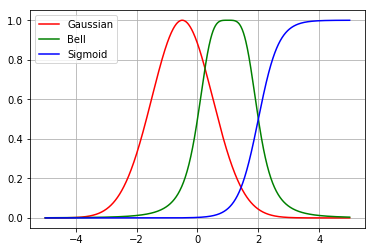

In [164]:
x = np.array(range(-500, 501))/100
gau = gaussmf(x=x, mean=-0.5, sigma=1)
bell = gbellmf(x=x, a=1, b=2, c=1)
sig = sigmf(x=x, b=2, c=3)

plt.plot(x, gau, 'r', label='Gaussian')
plt.plot(x, bell, 'g', label='Bell')
plt.plot(x, sig, 'b', label='Sigmoid')
plt.grid(True)
plt.legend()

## Membership function class

In [152]:
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 31 15:41:58 2014

@author: tim.meggs
"""

# from skfuzzy import gaussmf, gbellmf, sigmf

class MemFuncs:
    """Common base class for all employees"""
    
    funcDict = {'gaussmf': gaussmf, 'gbellmf': gbellmf, 'sigmf': sigmf}

    def __init__(self, MFList):
        self.MFList = MFList

    def evaluateMF(self, rowInput):
        if len(rowInput) != len(self.MFList):
            print("Number of variables does not match number of rule sets")
            
        return [
            [
                self.funcDict[
                    self.MFList[i][k][0]
                ](rowInput[i],**self.MFList[i][k][1]) 
                for k in range(len(self.MFList[i]))
            ] 
            for i in range(len(rowInput))
        ]

## Membership function derivative class

In [165]:
import numpy as np
def partial_dMF(x, mf_definition, partial_parameter):
    """
    Calculates the partial derivative of a membership function at a point x.
    This is for back-propagation over parameter
    Parameters
    ------
    Returns
    ------
    """
    mf_name = mf_definition[0]

    if mf_name == 'gaussmf':

        sigma = mf_definition[1]['sigma']
        mean = mf_definition[1]['mean']

        if partial_parameter == 'sigma':
            result = (1./sigma**3) * np.exp(-(((x-mean)**2)/(2*(sigma)**2)))*(x-mean)**2
        elif partial_parameter == 'mean':
            result = (1./sigma**2) * np.exp(-(((x-mean)**2)/(2*(sigma)**2)))*(x-mean)

    elif mf_name == 'gbellmf':

        a = mf_definition[1]['a']
        b = mf_definition[1]['b']
        c = mf_definition[1]['c']

        if partial_parameter == 'a':
            result = (2. * b * np.power((c-x),2) * np.power(np.absolute((c-x)/a), ((2 * b) - 2))) / \
                (np.power(a, 3) * np.power((np.power(np.absolute((c-x)/a),(2*b)) + 1), 2))
        elif partial_parameter == 'b':
            result = -1 * (2 * np.power(np.absolute((c-x)/a), (2 * b)) * np.log(np.absolute((c-x)/a))) / \
                (np.power((np.power(np.absolute((c-x)/a), (2 * b)) + 1), 2))
        elif partial_parameter == 'c':
            result = -(2. * b * (c-x) * np.power(np.absolute((c-x)/a), ((2 * b) - 2))) / \
                (np.power(a, 2) * np.power((np.power(np.absolute((c-x)/a),(2*b)) + 1), 2))

    elif mf_name == 'sigmf':

        b = mf_definition[1]['b']
        c = mf_definition[1]['c']

        if partial_parameter == 'b':
            result = -c * np.exp(c * (b - x)) / \
                np.power(np.exp(c * (b - x))+1, 2)
        elif partial_parameter == 'c':
            result = ((x - b) * np.exp(c * (b - x))) / \
                np.power(np.exp(c*(b-x)) + 1, 2)

    return result

### Test derivatives
#### Gausian

In [166]:
funDict = {'gaussmf': gaussmf, 'gbellmf': gbellmf, 'sigmf': sigmf}
mfdef = ['gaussmf', {'mean':0.,'sigma':1.}]
xtest = 0.5
eps = 0.001
ets_der = (funDict[mfdef[0]](xtest, mfdef[1]['mean']+eps, mfdef[1]['sigma'])\
           -funDict[mfdef[0]](xtest, mfdef[1]['mean']-eps, mfdef[1]['sigma']))/(2*eps)
ets_cal = partial_dMF(xtest, mfdef, 'mean')

print("Mean's difference:", ets_der - ets_cal)

ets_der = (funDict[mfdef[0]](xtest, mfdef[1]['mean'], mfdef[1]['sigma']+eps)\
           -funDict[mfdef[0]](xtest, mfdef[1]['mean'], mfdef[1]['sigma']-eps))/(2*eps)
ets_cal = partial_dMF(xtest, mfdef, 'sigma')
print("Sigma's difference:", ets_der - ets_cal)

Mean's difference: -2.022388480016346e-07
Sigma's difference: 3.608129017229622e-07


#### Bell function

In [167]:
mfdef = ['gbellmf', {'a': 1.5,'b': 2, 'c': 2.}]
xtest = 0.5
eps = 0.01

ets_der = (funDict[mfdef[0]](xtest, mfdef[1]['a']+eps, mfdef[1]['b'], mfdef[1]['c']) - \
          funDict[mfdef[0]](xtest, mfdef[1]['a']-eps, mfdef[1]['b'], mfdef[1]['c']))\
          /(2*eps)
ets_cal = partial_dMF(xtest, mfdef, 'a')

print("a's difference:", ets_der - ets_cal)

ets_der = (funDict[mfdef[0]](xtest, mfdef[1]['a'], mfdef[1]['b']+eps, mfdef[1]['c']) - \
          funDict[mfdef[0]](xtest, mfdef[1]['a'], mfdef[1]['b']-eps, mfdef[1]['c']))\
          /(2*eps)
ets_cal = partial_dMF(xtest, mfdef, 'b')

print("b's difference:", ets_der - ets_cal)

ets_der = (funDict[mfdef[0]](xtest, mfdef[1]['a'], mfdef[1]['b'], mfdef[1]['c']+eps) - \
          funDict[mfdef[0]](xtest, mfdef[1]['a'], mfdef[1]['b'], mfdef[1]['c']-eps))\
          /(2*eps)
ets_cal = partial_dMF(xtest, mfdef, 'c')

print("c's difference:", ets_der - ets_cal)

a's difference: -2.9629629448413297e-05
b's difference: 0.0
c's difference: 2.9629629453964412e-05


#### Sigmoid function

In [168]:
mfdef = ['sigmf', {'b': 1, 'c': 2.}]
xtest = 0.6
eps = 0.0001

ets_der = (funDict[mfdef[0]](xtest, mfdef[1]['b']+eps, mfdef[1]['c']) - \
          funDict[mfdef[0]](xtest, mfdef[1]['b']-eps, mfdef[1]['c']))\
          /(2*eps)
ets_cal = partial_dMF(xtest, mfdef, 'b')

print("b's difference:", ets_der - ets_cal)

ets_der = (funDict[mfdef[0]](xtest, mfdef[1]['b'], mfdef[1]['c']+eps) - \
          funDict[mfdef[0]](xtest, mfdef[1]['b'], mfdef[1]['c']-eps))\
          /(2*eps)
ets_cal = partial_dMF(xtest, mfdef, 'c')

print("c's difference:", ets_der - ets_cal)

b's difference: 8.086792901984552e-10
c's difference: 6.304637367726684e-12


## ANFIS class implement

In [148]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 03 07:30:34 2014
@author: tim.meggs
"""

class ANFIS:
    """Class to implement an Adaptive Network Fuzzy Inference System: ANFIS"

    Attributes:
        X - input
        Y - output
        XLen - input len
        memClass - membership function class
        memFuncs - membership function list
        memFuncsByVariable - membership function by variable
        rules - fuzzy rules
        consequents - ...[TODO]
        errors - ...[TODO]
        memFuncsHomo - ...[TODO]
        trainingType - ...[TODO]
    """

    def __init__(self, X, Y, memFunction):
        """
        Initialise ANFIS instance from
        - input X [TODO: give structure]
        - output Y [TODO: give structure]
        - membership function class memFunction [TODO: give structure]
        X.shape[0] - number of training sample
        X.shape[1] - number of inputs in fuzzy neural net
        """
        self.X = np.array(copy.copy(X))
        self.Y = np.array(copy.copy(Y))
        self.XLen = len(self.X)
        
        self.memClass = copy.deepcopy(memFunction)
        self.memFuncs = self.memClass.MFList
        
        self.memFuncsByVariable = [
            [x for x in range(len(self.memFuncs[z]))]
            for z in range(len(self.memFuncs))
        ]
        
        self.rules = np.array(list(itertools.product(*self.memFuncsByVariable)))
        
        self.consequents = np.empty(
            self.Y.ndim * len(self.rules) * (self.X.shape[1] + 1)
        )
        
        self.consequents.fill(0)
        self.errors = np.empty(0)
        
        self.memFuncsHomo = all(
            len(i)==len(self.memFuncsByVariable[0]) 
            for i in self.memFuncsByVariable
        )
        
        self.trainingType = 'Not trained yet'

    def trainHybridJangOffLine(self, epochs=5, tolerance=1e-5, initialGamma=1000, k=0.01):
        """
        Training fuzzy neural network
        """

        self.trainingType = 'trainHybridJangOffLine'
        convergence = False
        epoch = 1

        while (epoch < epochs) and (convergence is not True):

            #layer four: forward pass
            [layerFour, wSum, w] = forwardHalfPass(self, self.X)

            #layer five: least squares estimate
            layerFive = np.array(LSE(layerFour,self.Y,initialGamma))
            self.consequents = layerFive
            layerFive = np.dot(layerFour,layerFive)

            #error
            error = np.sum((self.Y-layerFive.T)**2)
            print('current error: ', error)
            average_error = np.average(np.absolute(self.Y-layerFive.T))
            self.errors = np.append(self.errors,error)

            if len(self.errors) != 0:
                if self.errors[len(self.errors)-1] < tolerance:
                    convergence = True

            # back propagation
            if convergence is not True:
                cols = range(len(self.X[0,:]))
                dE_dAlpha = list(backprop(self, colX, cols, wSum, w, layerFive) for colX in range(self.X.shape[1]))


            if len(self.errors) >= 4:
                if (self.errors[-4] > self.errors[-3] > self.errors[-2] > self.errors[-1]):
                    k = k * 1.1

            if len(self.errors) >= 5:
                if (self.errors[-1] < self.errors[-2]) and (self.errors[-3] < self.errors[-2]) and (self.errors[-3] < self.errors[-4]) and (self.errors[-5] > self.errors[-4]):
                    k = k * 0.9

            ## handling of variables with a different number of MFs
            t = []
            for x in range(len(dE_dAlpha)):
                for y in range(len(dE_dAlpha[x])):
                    for z in range(len(dE_dAlpha[x][y])):
                        t.append(dE_dAlpha[x][y][z])

            eta = k / np.abs(np.sum(t))

            if(np.isinf(eta)):
                eta = k

            ## handling of variables with a different number of MFs
            dAlpha = copy.deepcopy(dE_dAlpha)
            if not(self.memFuncsHomo):
                for x in range(len(dE_dAlpha)):
                    for y in range(len(dE_dAlpha[x])):
                        for z in range(len(dE_dAlpha[x][y])):
                            dAlpha[x][y][z] = -eta * dE_dAlpha[x][y][z]
            else:
                dAlpha = -eta * np.array(dE_dAlpha)


            for varsWithMemFuncs in range(len(self.memFuncs)):
                for MFs in range(len(self.memFuncsByVariable[varsWithMemFuncs])):
                    paramList = sorted(self.memFuncs[varsWithMemFuncs][MFs][1])
                    for param in range(len(paramList)):
                        self.memFuncs[varsWithMemFuncs][MFs][1][paramList[param]] = self.memFuncs[varsWithMemFuncs][MFs][1][paramList[param]] + dAlpha[varsWithMemFuncs][MFs][param]
            epoch = epoch + 1


        self.fittedValues = predict(self,self.X)
        self.residuals = self.Y - self.fittedValues[:,0]

        return self.fittedValues

    def plotErrors(self):
        if self.trainingType == 'Not trained yet':
            print(self.trainingType)
        else:
            import matplotlib.pyplot as plt
            plt.plot(range(len(self.errors)),self.errors,'ro', label='errors')
            plt.ylabel('error')
            plt.xlabel('epoch')
            plt.show()

    def plotMF(self, x, inputVar):
        import matplotlib.pyplot as plt
        from skfuzzy import gaussmf, gbellmf, sigmf

        for mf in range(len(self.memFuncs[inputVar])):
            if self.memFuncs[inputVar][mf][0] == 'gaussmf':
                y = gaussmf(x,**self.memClass.MFList[inputVar][mf][1])
            elif self.memFuncs[inputVar][mf][0] == 'gbellmf':
                y = gbellmf(x,**self.memClass.MFList[inputVar][mf][1])
            elif self.memFuncs[inputVar][mf][0] == 'sigmf':
                y = sigmf(x,**self.memClass.MFList[inputVar][mf][1])

            plt.plot(x,y,'r')

        plt.show()

    def plotResults(self):
        if self.trainingType == 'Not trained yet':
            print(self.trainingType)
        else:
            import matplotlib.pyplot as plt
            plt.plot(range(len(self.fittedValues)),self.fittedValues,'r', label='trained')
            plt.plot(range(len(self.Y)),self.Y,'b', label='original')
            plt.legend(loc='upper left')
            plt.show()
            
def LSE(A, B, initialGamma = 1000.):
        coeffMat = A
        rhsMat = B
        S = np.eye(coeffMat.shape[1])*initialGamma
        x = np.zeros((coeffMat.shape[1],1)) # need to correct for multi-dim B
        
        for i in range(len(coeffMat[:,0])):
            a = coeffMat[i,:]
            b = np.array(rhsMat[i])
            S = S - (np.array(np.dot(np.dot(np.dot(S,np.matrix(a).transpose()),np.matrix(a)),S)))/(1+(np.dot(np.dot(S,a),a)))
            x = x + (np.dot(S,np.dot(np.matrix(a).transpose(),(np.matrix(b)-np.dot(np.matrix(a),x)))))
        return x

def forwardHalfPass(ANFISObj, Xs):
    layerFour = np.empty(0,)
    wSum = []

    for pattern in range(len(Xs[:,0])):
        #layer one
        layerOne = ANFISObj.memClass.evaluateMF(Xs[pattern,:])

        #layer two
        miAlloc = [[layerOne[x][ANFISObj.rules[row][x]] for x in range(len(ANFISObj.rules[0]))] for row in range(len(ANFISObj.rules))]
        layerTwo = np.array([np.product(x) for x in miAlloc]).T
        if pattern == 0:
            w = layerTwo
        else:
            w = np.vstack((w,layerTwo))

        #layer three
        wSum.append(np.sum(layerTwo))
        if pattern == 0:
            wNormalized = layerTwo/wSum[pattern]
        else:
            wNormalized = np.vstack((wNormalized,layerTwo/wSum[pattern]))

        #prep for layer four (bit of a hack)
        layerThree = layerTwo/wSum[pattern]
        rowHolder = np.concatenate([x*np.append(Xs[pattern,:],1) for x in layerThree])
        layerFour = np.append(layerFour,rowHolder)

    w = w.T
    wNormalized = wNormalized.T

    layerFour = np.array(np.array_split(layerFour,pattern + 1))

    return layerFour, wSum, w


def backprop(ANFISObj, columnX, columns, theWSum, theW, theLayerFive):

    paramGrp = [0]* len(ANFISObj.memFuncs[columnX])
    for MF in range(len(ANFISObj.memFuncs[columnX])):

        parameters = np.empty(len(ANFISObj.memFuncs[columnX][MF][1]))
        timesThru = 0
        for alpha in sorted(ANFISObj.memFuncs[columnX][MF][1].keys()):

            bucket3 = np.empty(len(ANFISObj.X))
            for rowX in range(len(ANFISObj.X)):
                varToTest = ANFISObj.X[rowX,columnX]
                tmpRow = np.empty(len(ANFISObj.memFuncs))
                tmpRow.fill(varToTest)

                bucket2 = np.empty(ANFISObj.Y.ndim)
                for colY in range(ANFISObj.Y.ndim):

                    rulesWithAlpha = np.array(np.where(ANFISObj.rules[:,columnX]==MF))[0]
                    adjCols = np.delete(columns,columnX)

                    senSit = partial_dMF(ANFISObj.X[rowX,columnX],ANFISObj.memFuncs[columnX][MF],alpha)
                    # produces d_ruleOutput/d_parameterWithinMF
                    dW_dAplha = senSit * np.array([np.prod([ANFISObj.memClass.evaluateMF(tmpRow)[c][ANFISObj.rules[r][c]] for c in adjCols]) for r in rulesWithAlpha])

                    bucket1 = np.empty(len(ANFISObj.rules[:,0]))
                    for consequent in range(len(ANFISObj.rules[:,0])):
                        fConsequent = np.dot(np.append(ANFISObj.X[rowX,:],1.),ANFISObj.consequents[((ANFISObj.X.shape[1] + 1) * consequent):(((ANFISObj.X.shape[1] + 1) * consequent) + (ANFISObj.X.shape[1] + 1)),colY])
                        acum = 0
                        if consequent in rulesWithAlpha:
                            acum = dW_dAplha[np.where(rulesWithAlpha==consequent)] * theWSum[rowX]

                        acum = acum - theW[consequent,rowX] * np.sum(dW_dAplha)
                        acum = acum / theWSum[rowX]**2
                        bucket1[consequent] = fConsequent * acum

                    sum1 = np.sum(bucket1)

                    if ANFISObj.Y.ndim == 1:
                        bucket2[colY] = sum1 * (ANFISObj.Y[rowX]-theLayerFive[rowX,colY])*(-2)
                    else:
                        bucket2[colY] = sum1 * (ANFISObj.Y[rowX,colY]-theLayerFive[rowX,colY])*(-2)

                sum2 = np.sum(bucket2)
                bucket3[rowX] = sum2

            sum3 = np.sum(bucket3)
            parameters[timesThru] = sum3
            timesThru = timesThru + 1

        paramGrp[MF] = parameters

    return paramGrp


def predict(ANFISObj, varsToTest):

    [layerFour, wSum, w] = forwardHalfPass(ANFISObj, varsToTest)

    #layer five
    layerFive = np.dot(layerFour,ANFISObj.consequents)

    return layerFive

In [146]:
# import membership
# import anfis
# import membership #import membershipfunction, mfDerivs
import numpy


ts = numpy.loadtxt("/home/hung/githubtest/anfis/anfistest/trainingSet.txt", usecols=[1,2,3])#numpy.loadtxt('c:\\Python_fiddling\\myProject\\MF\\trainingSet.txt',usecols=[1,2,3])
X = ts[:,0:2]
Y = ts[:,2]

mf = \
[
    [
        ['gaussmf', {'mean':0.,'sigma':1.}],
        ['gaussmf', {'mean':-1.,'sigma':2.}],
        ['gaussmf', {'mean':-4.,'sigma':10.}],
        ['gaussmf', {'mean':-7.,'sigma':7.}]
    ],
    [
        ['gaussmf', {'mean':1.,'sigma':2.}],
        ['gaussmf', {'mean':2.,'sigma':3.}],
        ['gaussmf', {'mean':-2.,'sigma':10.}],
        ['gaussmf', {'mean':-10.5,'sigma':5.}]
    ]
]

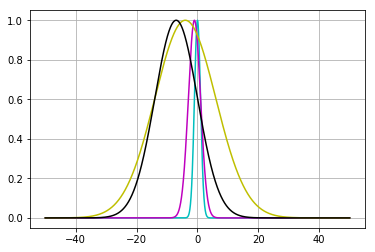

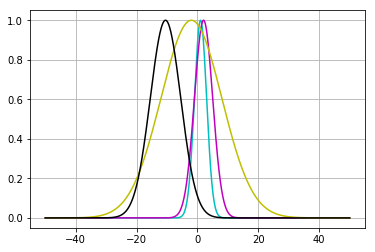

In [75]:
# initial mf plot
xx = np.array(range(-5000, 5001))/100
yy = np.zeros((2,4,xx.shape[0]))
color = ['c', 'm', 'y', 'k']
for i in range(2):
    plt.figure()
    for j in range(4):
        mean = mf[i][j][1]['mean']
        sigma = mf[i][j][1]['sigma']
        yy[i,j,:] = gaussmf(xx, mean, sigma)
        plt.plot(xx, yy[i][j], color[j])
    plt.grid(True)

current error:  0.32197133130240374
current error:  0.3244395435172118
current error:  0.32737037732717333
current error:  0.3308638679244012
current error:  0.3350469671896102
current error:  0.34008097208675436
current error:  0.3461693238692687
current error:  0.35356261646171727
current error:  0.36255251716219034
current error:  0.3734367868961723
current error:  0.3864273056430959
current error:  0.4014855105516483
current error:  0.4181523958968241
current error:  0.4355619577288206
current error:  0.4527403743450915
current error:  0.46895469096953235
current error:  0.48382914042831504
current error:  0.4972604197656211
current error:  0.5092943311428818
0.292591
0.038271
0.007345


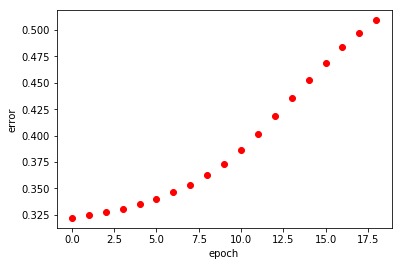

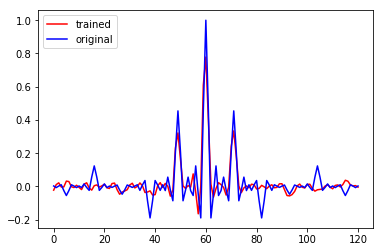

In [149]:
mfc = MemFuncs(mf)
anf = ANFIS(X, Y, mfc)
anf.trainHybridJangOffLine(epochs=20)
print(round(anf.consequents[-1][0],6))
print(round(anf.consequents[-2][0],6))
print(round(anf.fittedValues[9][0],6))
if round(anf.consequents[-1][0],6) == -5.275538 and round(anf.consequents[-2][0],6) == -1.990703 and round(anf.fittedValues[9][0],6) == 0.002249:
    print('test is good')
anf.plotErrors()
anf.plotResults()

In [178]:
mfc.evaluateMF(np.array([[1],[2]]))

[[array([0.60653066]),
  array([0.60653066]),
  array([0.8824969]),
  array([0.52045012])],
 [array([0.8824969]), array([1.]), array([0.92311635]), array([0.04393693])]]

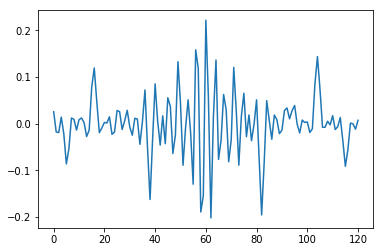

In [144]:
plt.plot((Y-np.squeeze(predict(anf, X))))

In [145]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(np.matrix(Y).transpose(), predict(anf, X))

0.044351673639813675

Text(0.5,0,'Z-axis')

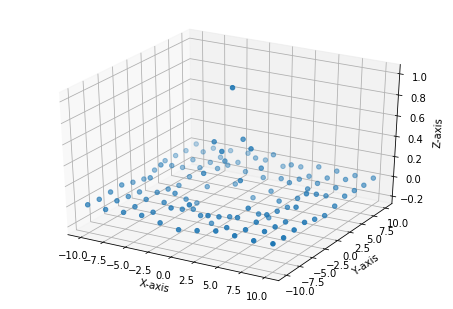

In [134]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(ts[:, 0], ts[:, 1], ts[:, 2], )
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')